In [124]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
import statsmodels.formula.api as smf
import datetime


# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [125]:
y = pd.read_csv('AAPL_quarterly_financials.csv', parse_dates = True)
#Lets clean the data, we will eventually get the names that are dates as columns
y.index = y.name #This makes the name column the index
y = pd.DataFrame(y.loc["BasicEPS",:]).iloc[2:,:] #This makes the index the name column
y.index = pd.to_datetime(y.index) #This makes the index a datetime object



In [126]:
#Check if NA are no dividend period
y = y.sort_index().fillna(0.)
y

,BasicEPS
1985-09-30,0.0
1985-12-31,0.004
1986-03-31,0.002
1986-06-30,0.002
1986-09-30,0.0
...,...
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27


# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.


In [127]:
from pytrends.request import TrendReq

In [128]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Iphone", "Recession","Jobs","Inflation","loan","Interest Rate","Taylor Swift","Hospital","UCLA"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2023-09-30'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [129]:
df = df.resample("Q").mean()
df

,Iphone,Recession,Jobs,Inflation,loan,Interest Rate,Taylor Swift,Hospital,UCLA
date,,,,,,,,,
2004-03-31,0.000000,7.333333,62.000000,46.666667,51.000000,36.333333,0.000000,77.333333,85.333333
2004-06-30,0.000000,7.666667,62.333333,44.333333,55.000000,40.333333,0.000000,75.666667,84.333333
2004-09-30,0.000000,6.000000,60.000000,36.000000,55.333333,34.333333,0.000000,79.666667,76.333333
2004-12-31,0.000000,7.333333,52.333333,40.000000,44.000000,32.333333,0.000000,73.666667,84.333333
2005-03-31,0.000000,5.666667,57.333333,39.666667,47.333333,31.666667,0.000000,78.666667,80.333333
...,...,...,...,...,...,...,...,...,...
2022-09-30,51.666667,56.333333,49.333333,93.333333,87.333333,82.000000,20.333333,86.000000,31.000000
2022-12-31,49.000000,49.000000,43.333333,79.666667,78.000000,87.000000,45.333333,76.000000,41.666667
2023-03-31,49.666667,36.666667,50.666667,75.666667,83.000000,94.666667,34.000000,81.666667,43.000000


# 2.) Normalize all the X data

In [130]:
from sklearn.preprocessing import StandardScaler

In [131]:
scaler = StandardScaler()

In [132]:
X_Scaled = scaler.fit_transform(df)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [133]:
from sklearn.linear_model import Lasso

In [134]:
y = y[y.index > datetime.datetime(2004,1,1)]
y

,BasicEPS
2004-03-31,0.002
2004-06-30,0.003
2004-09-30,0.0
2004-12-31,0.013
2005-03-31,0.013
...,...
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27


In [135]:
lasso = Lasso(alpha=0.5)
lasso.fit(X_Scaled,y)

Lasso(alpha=0.5)

In [136]:
coefficients = lasso.coef_

In [137]:
coefficients

array([ 0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.])

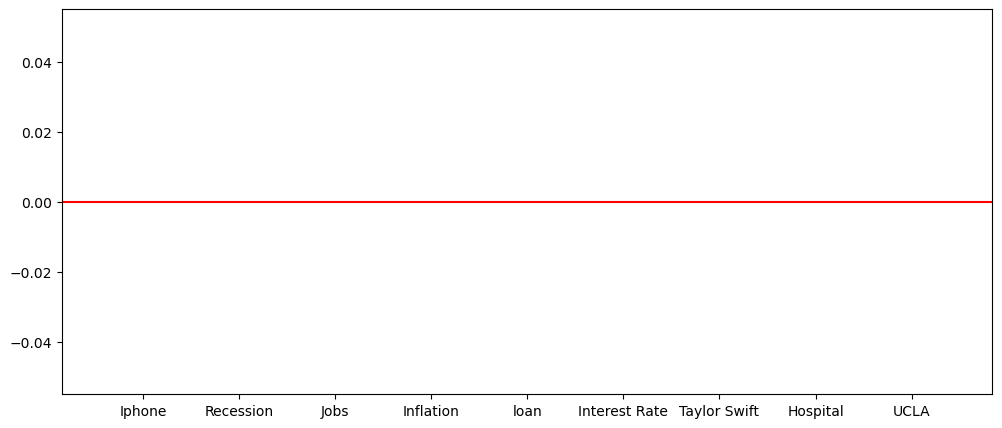

In [138]:
plt.figure(figsize = (12,5))
plt.bar(range(len(coefficients)), coefficients, tick_label = df.columns)
plt.axhline(0, color='red')
plt.show()

# 5.) Do these coefficient magnitudes make sense?

In [139]:
#Yes. I would mean that these variables are not important for the model as strong in the model for them to surpass a lambda of value 0.5. The coefficients are 0.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

In [140]:
#Now we test for 10 different lambadas using a loop
lambdas = np.linspace(0.1, 0.5, 10).round(2)

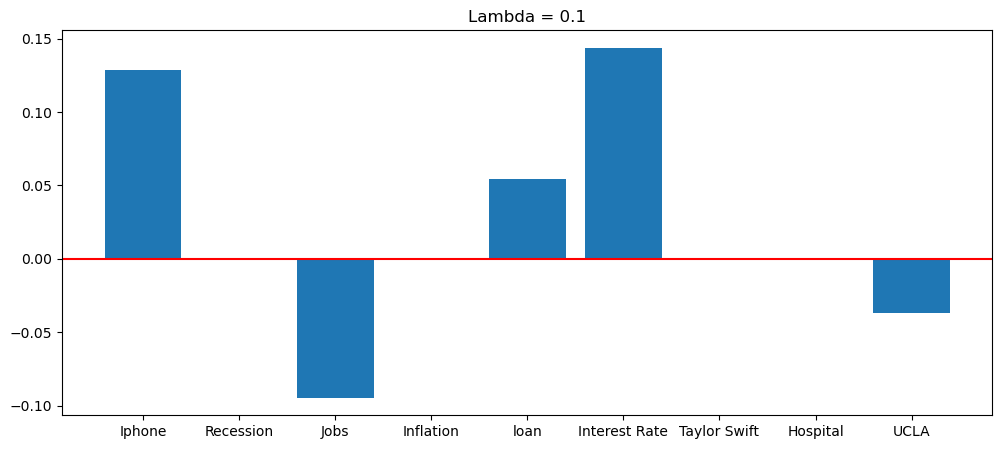

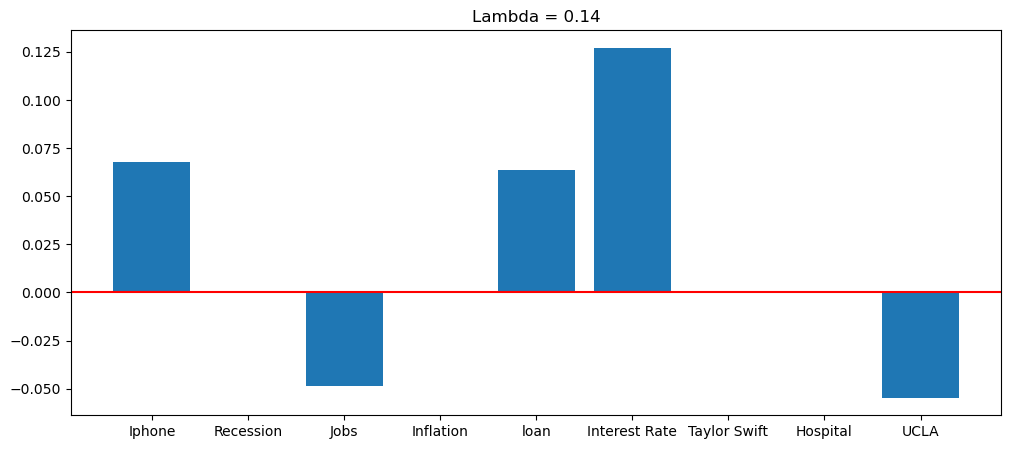

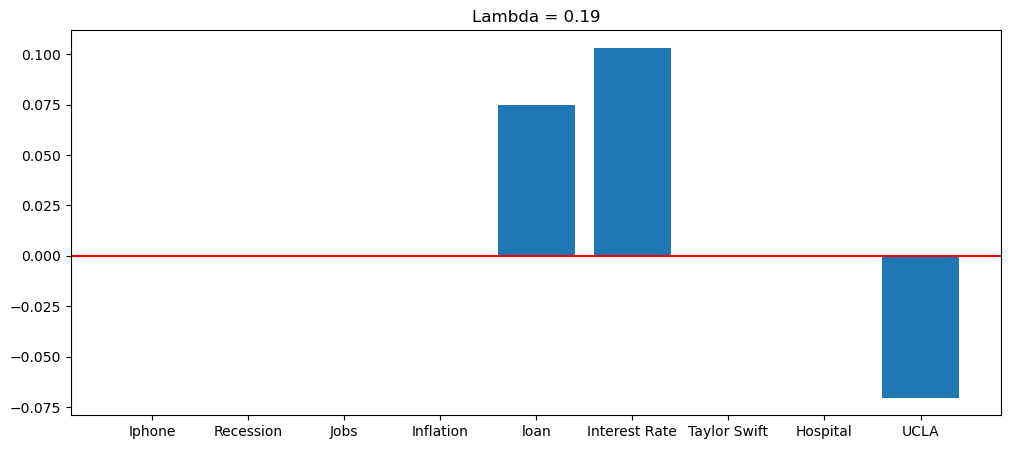

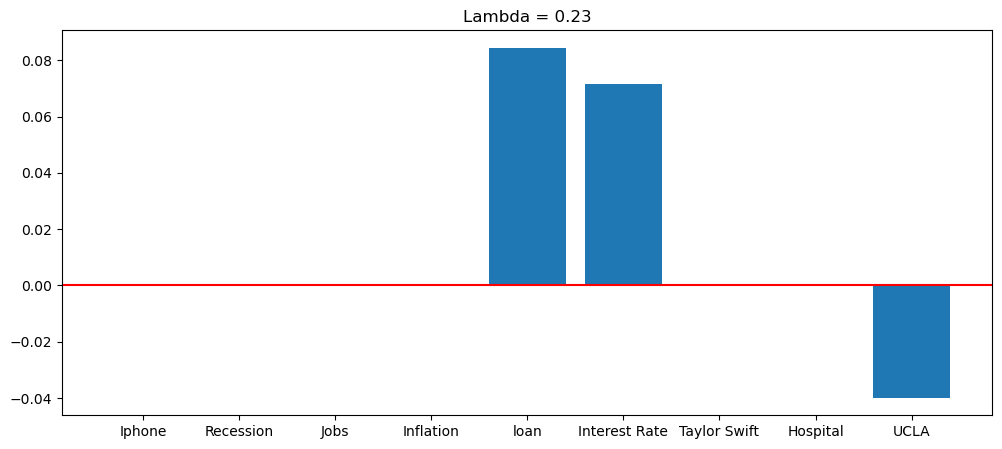

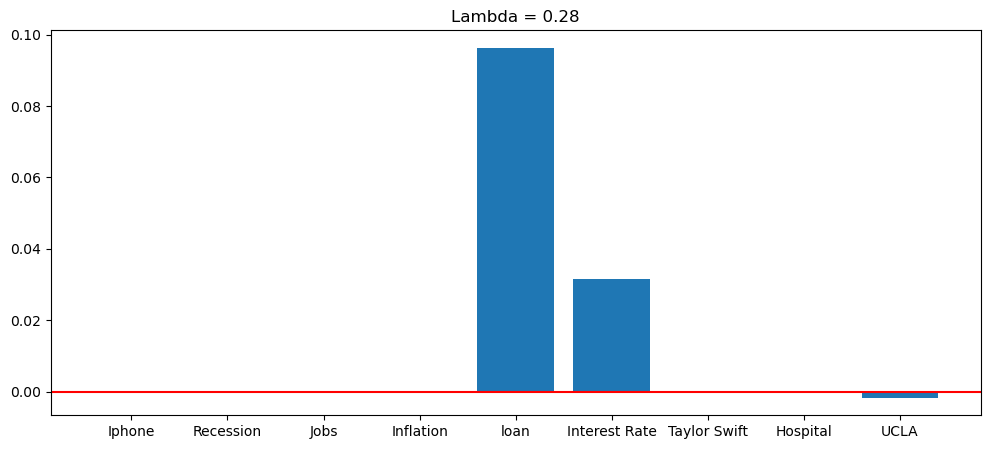

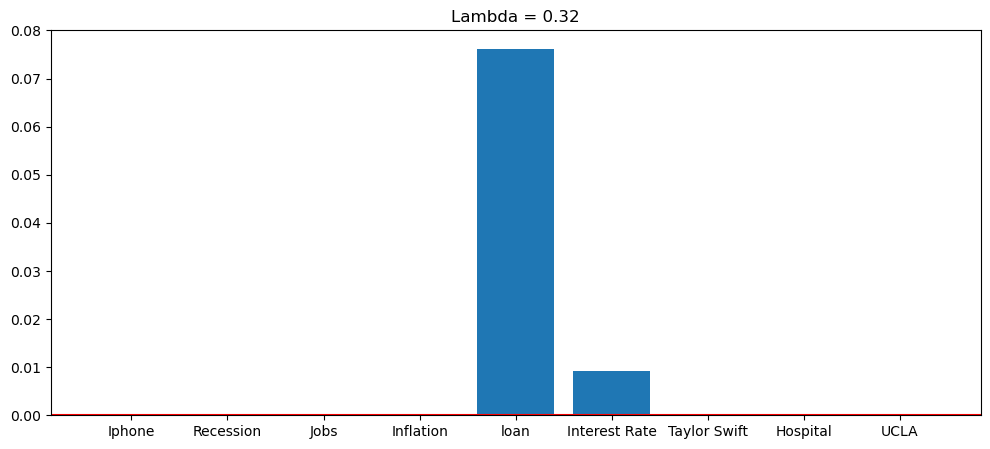

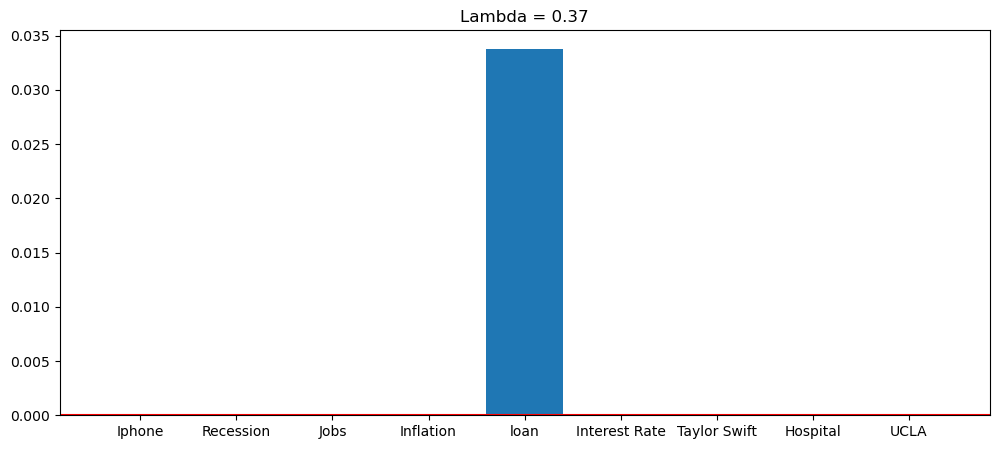

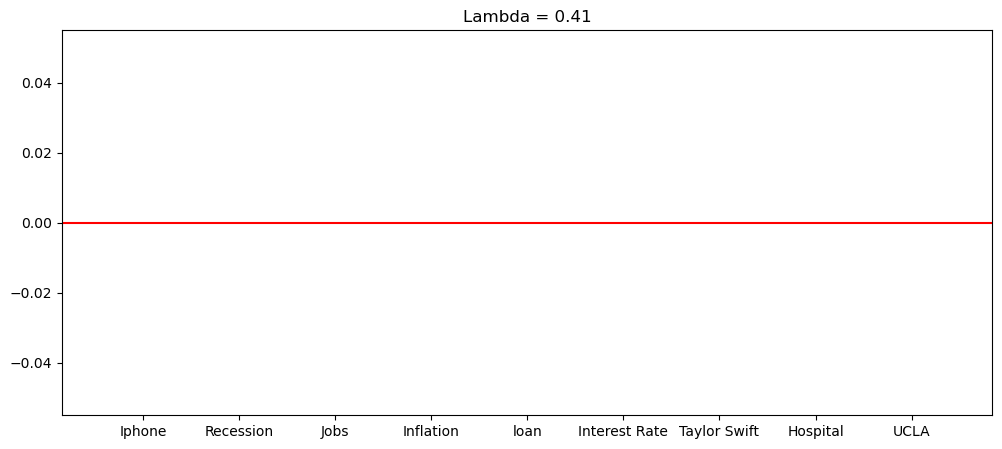

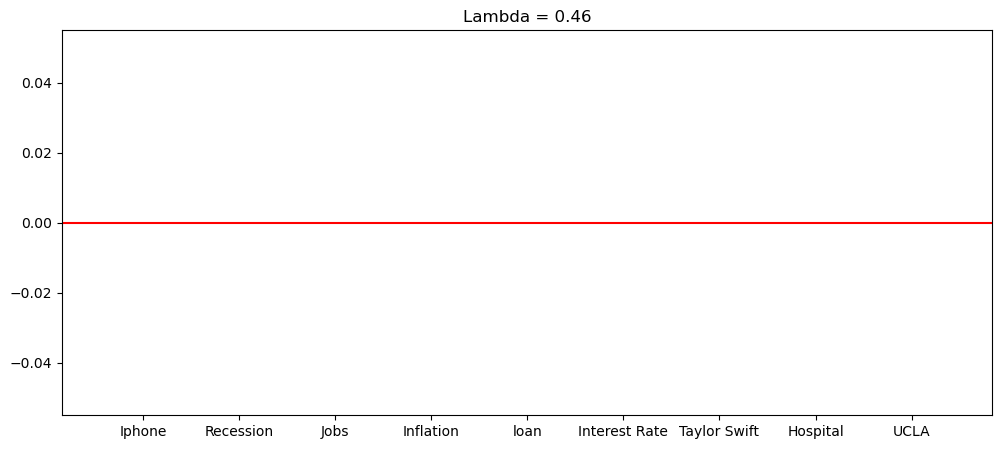

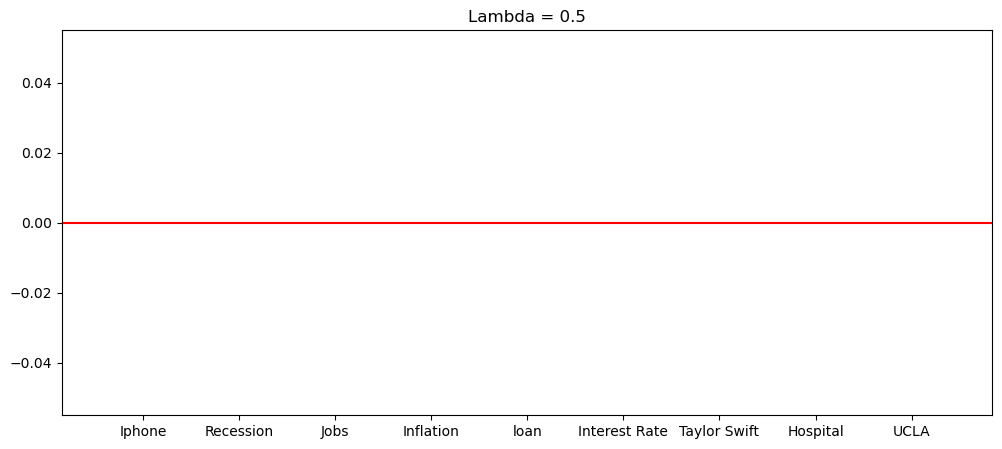

In [141]:
for i in lambdas:
    lasso = Lasso(alpha=i)
    lasso.fit(X_Scaled,y)
    coefficients = lasso.coef_
    plt.figure(figsize = (12,5))
    plt.bar(range(len(coefficients)), coefficients, tick_label = df.columns)
    plt.axhline(0, color='red')
    plt.title(f"Lambda = {i}")
    plt.show()

# 7.) Run a cross validation. What is your ideal lambda?

In [142]:
#Now we run a cross validation to find the best lambda
from sklearn.linear_model import LassoCV
modCV = LassoCV().fit(X_Scaled, y)
a = modCV.alpha_
print("The best alpha is",round(a,3))


The best alpha is 0.007


/Users/luisj/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
